In [50]:
from __future__ import print_function
from urllib2 import HTTPError
from urllib import quote
from urllib import urlencode
from pprint import pprint

import argparse
import json
import pprint
import requests
import sys
import urllib
import time

from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression as LogReg

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [2]:
# OAuth credential placeholders
CLIENT_ID = 'sd5Ge9lqAHFdxK_wSPp3QA'
CLIENT_SECRET = 'DRLcojBT3IAM1kVJDViB6QOHmjEIHEubFTpqHdfLHoEiTJSgEFt5Peqzbcajve7K'


In [3]:
# API constants, you shouldn't have to change these.
API_HOST = 'https://api.yelp.com'
SEARCH_PATH = '/v3/businesses/search'
BUSINESS_PATH = '/v3/businesses/'  # Business ID will come after slash.
TOKEN_PATH = '/oauth2/token'
GRANT_TYPE = 'client_credentials'

In [4]:
url = 'https://api.yelp.com/oauth2/token'
payload = {'grant_type':'client_credentials','client_id':'sd5Ge9lqAHFdxK_wSPp3QA','client_secret':'DRLcojBT3IAM1kVJDViB6QOHmjEIHEubFTpqHdfLHoEiTJSgEFt5Peqzbcajve7K'}

r = requests.post(url, data=payload)

In [5]:
r.text

u'{"expires_in": 15216754, "token_type": "Bearer", "access_token": "n2C-ZzYcr5oDGNJBiHiqLGfFBtHi6cKcgDDuQNyrHXU8pgwmyaH2hZ54C4OD4L7OyzONVS2UTbPqjsDsrW_QXNIOkOfoSjTS5dvW9OeMUXFoOj6qdW5jSGq4nsdMWHYx"}'

In [6]:
TOKEN = "n2C-ZzYcr5oDGNJBiHiqLGfFBtHi6cKcgDDuQNyrHXU8pgwmyaH2hZ54C4OD4L7OyzONVS2UTbPqjsDsrW_QXNIOkOfoSjTS5dvW9OeMUXFoOj6qdW5jSGq4nsdMWHYx"
#return 5 results by default
SEARCH_LIMIT = 1

In [7]:
def request(host, path, bearer_token, url_params=None):
    """Given a bearer token, send a GET request to the API.
    Args:
        host (str): The domain host of the API.
        path (str): The path of the API after the domain.
        bearer_token (str): OAuth bearer token, obtained using client_id and client_secret.
        url_params (dict): An optional set of query parameters in the request.
    Returns:
        dict: The JSON response from the request.
    Raises:
        HTTPError: An error occurs from the HTTP request.
    """
    url_params = url_params or {}
    url = '{0}{1}'.format(host, quote(path.encode('utf8')))
    headers = {
        'Authorization': 'Bearer %s' % bearer_token,
    }

    print(u'Querying {0} ...'.format(url))

    response = requests.request('GET', url, headers=headers, params=url_params)

    return response.json()

In [8]:
def search(bearer_token, term, location):
    """Query the Search API by a search term and location.
    Args:
        term (str): The search term passed to the API.
        location (str): The search location passed to the API.
    Returns:
        dict: The JSON response from the request.
    """

    url_params = {
        'term': term.replace(' ', '+'),
        'location': location.replace(' ', '+'),
        'limit': SEARCH_LIMIT
    }
    return request(API_HOST, SEARCH_PATH, bearer_token, url_params=url_params)

In [9]:
#test the search function
response = search(TOKEN, 'dominos', 'chicago')

Querying https://api.yelp.com/v3/businesses/search ...


In [10]:
response

{u'businesses': [{u'categories': [{u'alias': u'pizza', u'title': u'Pizza'},
    {u'alias': u'chicken_wings', u'title': u'Chicken Wings'},
    {u'alias': u'sandwiches', u'title': u'Sandwiches'}],
   u'coordinates': {u'latitude': 41.9244149, u'longitude': -87.7420833},
   u'distance': 5740.245410879999,
   u'id': u'dominos-pizza-chicago-11',
   u'image_url': u'',
   u'is_closed': False,
   u'location': {u'address1': u'4608 W Fullerton Ave',
    u'address2': u'',
    u'address3': u'',
    u'city': u'Chicago',
    u'country': u'US',
    u'state': u'IL',
    u'zip_code': u'60639'},
   u'name': u"Domino's Pizza",
   u'phone': u'+17737729000',
   u'price': u'$$',
   u'rating': 3.5,
   u'review_count': 19,
   u'url': u'https://www.yelp.com/biz/dominos-pizza-chicago-11?adjust_creative=sd5Ge9lqAHFdxK_wSPp3QA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=sd5Ge9lqAHFdxK_wSPp3QA'}],
 u'total': 104}

In [11]:
#test how to get info out of json file
price = []
rating = []
estab_price = response['businesses'][0]["price"]
estab_rating = response['businesses'][0]["rating"] 
price.append(estab_price)
rating.append(estab_rating)
price

[u'$$']

In [13]:
#let's mess with our data...
insp = pd.read_csv('C:/Users/Joeseph/Dropbox/HGSE/CS109a Data Science/final project/data/Food_Inspections_Clean2.csv')
insp['date'] = pd.to_datetime(insp['Inspection Date'].astype('str'),infer_datetime_format=True)
insp.loc[:,'day_of_week']=insp.date.dt.dayofweek.values
insp.loc[:,'day_of_year']=insp.date.dt.dayofyear.values
insp.rename(columns={'AKA Name':'name','License #':'license','Inspection ID':'ID','Facility Type':'facility','Inspection Type':'inspection_type'},
            inplace=True)
insp = insp.query('facility in ["Restaurant","Grocery Store","Bakery"]')
insp = insp[['name','ID','license','date','Results','Risk','facility','inspection_type',
             'month','day','year','day_of_week','day_of_year','Latitude','Longitude','Zip']]
insp.head()

,name,ID,license,date,Results,Risk,facility,inspection_type,month,day,year,day_of_week,day_of_year,Latitude,Longitude,Zip
0,IYANZE,1970470,1909713.0,2016-10-28,1.0,1.0,Restaurant,Short Form Complaint,10,28,2016,4,302,41.966063,-87.657734,60640.0
2,DOMINOS,1970461,2464564.0,2016-10-28,0.0,2.0,Restaurant,Complaint Re-Inspection,10,28,2016,4,302,41.866277,-87.639360,60607.0
4,FIRST SLICE,1970429,1620340.0,2016-10-28,2.0,1.0,Restaurant,Complaint,10,28,2016,4,302,41.961619,-87.673833,60640.0
5,MCDONALDS,1951297,2349672.0,2016-10-28,0.0,2.0,Restaurant,Complaint,10,28,2016,4,302,41.883717,-87.626086,60602.0
6,PIZZA Y PAN PA' YA CORP.,1970418,2496099.0,2016-10-28,0.0,1.0,Restaurant,License,10,28,2016,4,302,41.961086,-87.706726,60618.0


In [14]:
#make sure all the names are strings (got a float error once...)
insp['name'] = insp['name'].astype(str)

In [15]:
n = insp.shape[0]
price = np.zeros(n)
rating = np.zeros(n)
insp['price'] = price
insp['rating'] = rating

In [44]:
%%time

for i in range(16310,n):
    print('Results for row {}:'.format(i))
    response = search(TOKEN, insp.iloc[i,0], 'chicago')
    time.sleep(1)
    if response['total'] == 0:
        insp.iloc[i,16] = 0
        insp.iloc[i,17] = 0
    elif 'price' not in (response['businesses'][0] or response['businesses']):
        insp.iloc[i,16] = 0
        insp.iloc[i,17] = 0
    else:
        insp.iloc[i,16] = response['businesses'][0]["price"]
        insp.iloc[i,17] = response['businesses'][0]["rating"]

Results for row 16310:
Querying https://api.yelp.com/v3/businesses/search ...
Results for row 16311:
Querying https://api.yelp.com/v3/businesses/search ...
Results for row 16312:
Querying https://api.yelp.com/v3/businesses/search ...
Results for row 16313:
Querying https://api.yelp.com/v3/businesses/search ...
Results for row 16314:
Querying https://api.yelp.com/v3/businesses/search ...
Results for row 16315:
Querying https://api.yelp.com/v3/businesses/search ...
Results for row 16316:
Querying https://api.yelp.com/v3/businesses/search ...
Results for row 16317:
Querying https://api.yelp.com/v3/businesses/search ...
Results for row 16318:
Querying https://api.yelp.com/v3/businesses/search ...


ValueError: No JSON object could be decoded

In [45]:
insp.to_csv('insp_yelp.csv', sep=',')

In [23]:
insp_yelp = pd.read_csv('C:/Users/CORSAIR/Dropbox/HGSE/CS109a Data Science/final project/insp_yelp.csv', sep = ',')
insp_yelp.head()

C:\Users\CORSAIR\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,name,ID,license,date,Results,Risk,facility,inspection_type,month,day,year,day_of_week,day_of_year,Latitude,Longitude,Zip,price,rating
0,IYANZE,1970470,1909713.0,10/28/2016,1,1.0,Restaurant,Short Form Complaint,10,28,2016,4,302,41.966063,-87.657734,60640.0,$$,3.0
1,DOMINOS,1970461,2464564.0,10/28/2016,0,2.0,Restaurant,Complaint Re-Inspection,10,28,2016,4,302,41.866277,-87.639360,60607.0,$$,3.5
2,FIRST SLICE,1970429,1620340.0,10/28/2016,2,1.0,Restaurant,Complaint,10,28,2016,4,302,41.961619,-87.673833,60640.0,$,4.5
3,MCDONALDS,1951297,2349672.0,10/28/2016,0,2.0,Restaurant,Complaint,10,28,2016,4,302,41.883717,-87.626086,60602.0,$,3.0
4,PIZZA Y PAN PA' YA CORP.,1970418,2496099.0,10/28/2016,0,1.0,Restaurant,License,10,28,2016,4,302,41.961086,-87.706726,60618.0,$$$,4.5


In [24]:
insp_yelp['price'] = insp_yelp['price'].astype(str)
dollars = {'0': '0',
           '0.0': '0',
           '1': '1',
           '2': '2',
           '3': '3',
           '4': '4',
           '5': '5',
           '$': '1',
           '$$': '2',
           '$$$': '3',
           '$$$$': '4',
           '$$$$$': '5'}
for i in range(insp_yelp.shape[0]):
    insp_yelp.iloc[i,16] = dollars[insp_yelp.iloc[i,16]]

In [25]:
insp_yelp.price.value_counts().head(10)

0    84108
1     5874
2     5724
3      766
4      272
Name: price, dtype: int64

In [26]:
insp_yelp = insp_yelp[insp_yelp.price != '0']
insp_yelp.price.value_counts().head(10)

1    5874
2    5724
3     766
4     272
Name: price, dtype: int64

In [27]:
insp_yelp['price'] = insp_yelp['price'].astype(int)

In [28]:
insp_yelp.rating.value_counts().head(10)

4.0    4252
3.5    3149
4.5    1884
3.0    1812
5.0     742
2.5     562
2.0     153
1.5      49
1.0      32
0.0       1
Name: rating, dtype: int64

In [30]:
#load other data
# Weather
weath_big = pd.read_csv('C:/Users/CORSAIR/Dropbox/HGSE/CS109a Data Science/final project/data/Weather_clean.csv',parse_dates=[6])
weath = weath_big[['date','tmax','tavg']]

# Complaints
comp_big = pd.read_csv('C:/Users/CORSAIR/Dropbox/HGSE/CS109a Data Science/final project/data/311_clean.csv',parse_dates=[0,2])
#comp = comp_big[['created','nature','zip','longitude','latitude','ward','police district','community area']]
comp = comp_big[['created','nature','longitude','latitude']]

In [31]:
# Convert longitude,latitude pairs to x-y coordinates.
# I arbitrarily made a reference point (0,0) at -88,41.  This is slightly southwest of the city.
# Then, I converted long,lat coordinates to x,y in kilometers:

long_ref,lat_ref = -88,41
lat_to_km = 111.07
long_to_km = 83.00733

def longlat2xy(longitude,latitude):
    x = (longitude-long_ref)*long_to_km
    y = (latitude-lat_ref)*lat_to_km
    return x,y

# Convert the locations in inspections and complaints.
insp.loc[:,'x'],insp.loc[:,'y'] = longlat2xy(insp['Longitude'].values,insp['Latitude'].values)
comp.loc[:,'x'],comp.loc[:,'y'] = longlat2xy(comp['longitude'].values,comp['latitude'].values)

C:\Users\CORSAIR\Anaconda2\lib\site-packages\pandas\core\indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\CORSAIR\Anaconda2\lib\site-packages\pandas\core\indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [33]:
# Filter inspection types
insp = insp.query('inspection_type in ["Canvass","Complaint","Short Form Complaint","Suspected Food Poisoning"]')

In [34]:
# Filter facility types
insp = insp.query('facility in ["Restaurant","Grocery Store","Bakery"]')

In [35]:
# Drop records with no license.
insp = insp[insp.license.notnull()]
# Drop records with no location.
insp = insp[insp.Latitude.notnull()]

In [39]:
# get 3-day high temp from weather data
weath = weath_big[['date','tmax','tavg']]
weath.ix[2494:2495,'tmax'] = weath.ix[2494:2495,'tavg']
weath = weath.drop('tavg',axis=1)

weath.ix[:,'tavg_3day']=weath['tmax'].rolling(window=3,min_periods=1).mean()
insp = pd.merge(insp,weath[['date','tmax','tavg_3day']],how='left',on='date').set_index(insp.index)

In [41]:
#risk, facility, and inspection type
it_dummies = pd.get_dummies(insp.inspection_type,prefix='it').drop('it_Canvass',axis=1)
ft_dummies = pd.get_dummies(insp.facility,prefix='ft').drop('ft_Restaurant',axis=1)
risk_dummies = pd.get_dummies(insp.Risk,prefix='risk').drop('risk_1.0',axis=1)
price_dummies = pd.get_dummies(insp.price,prefix='price').drop('price_0',axis=1)
rating_dummies = pd.get_dummies(insp.rating,prefix='rating').drop('rating_0.0',axis=1)

#get rid of rare zips
insp.loc[:,'zip2'] = insp.Zip.copy()
smallzip_idx = insp.zip2.value_counts()<1000
smallzips = smallzip_idx.index[smallzip_idx]
insp.ix[insp.zip2.isin(smallzips),'zip2']=np.nan
zip_dummies = pd.get_dummies(insp.zip2)

In [42]:
#loss function
# Return the tuple (average neg log loss, characteristic probability)
def log_loss(Ytrue,Ypred):
    badidx = np.isnan(Ytrue)
    Ytrue = Ytrue[~badidx]
    Ypred = Ypred[~badidx,:]
    n,m = Ypred.shape
    
    if not np.issubdtype(Ytrue.dtype,np.integer):
        Ytrue = Ytrue.copy().astype('int')
    
    # p is the predicted probability of the event that happened
    p = Ypred[np.arange(n),Ytrue]
    # A hack to avoid being certain something will never happen
    # This sets the minimum value to 0.01
    x = 0.01031
    p = (p+x)/(1+3*x)
    
    ave_loss = -np.log(p).mean()
    char_p = np.exp(-ave_loss)
    return ave_loss,char_p

In [43]:
# drop the first year.
insp_final = insp[insp.year != 2011]

In [44]:
#gather all relevant predictors
insp_final = insp_final[[u'name', u'ID', u'license', u'date',
       u'Results', u'Risk', u'facility', u'inspection_type', u'month', u'day',
       u'year', u'day_of_week', u'day_of_year', u'Latitude', u'Longitude',
       u'Zip', u'price', u'rating', u'x', u'y', u'tmax', u'tavg_3day',
       u'zip2']]
insp_final.columns

# Get the outcomes of the inspections;
# Delete the rows with missing outcomes.
Yall = insp_final.Results.values
badidx = np.isnan(Yall)
Y = Yall[~badidx]

In [47]:
# Make logistic models adding factors to the dow-year-zip (time-place models)

# Do 10-fold CV to estimate generalization ability of the models.

n = Y.shape[0]
n_folds = 10
kf = TimeSeriesSplit(n_splits=n_folds)

model_names = ['baseline','insp_type+fac_type+risk','+price','+rating']
n_models = len(model_names)

# Define the predictors for each model
X1 = pd.concat((it_dummies,ft_dummies,risk_dummies),axis=1).values
X0 = (X1[:,0]*0+1).reshape(-1,1)
X2 = pd.concat((it_dummies,ft_dummies,risk_dummies,
               price_dummies),axis=1).values
X3 = pd.concat((it_dummies,ft_dummies,risk_dummies,
               price_dummies,rating_dummies),axis=1).values


# Aggregate the predictors for all the models
allX = []
for i in range(n_models):
    allX.append(eval('X{}'.format(i)))

# Loop through the k-folds
mll = np.empty((n_folds,n_models))
charp = np.empty_like(mll)
for i,(ktrain,ktest) in enumerate(kf.split(Y)):
    
    for j in range(n_models):
        mdl = LogReg(C=1000).fit(allX[j][ktrain,:],Y[ktrain])
        Yproba = mdl.predict_proba(allX[j][ktest,:])
        mll[i,j],charp[i,j] = log_loss(Y[ktest],Yproba)

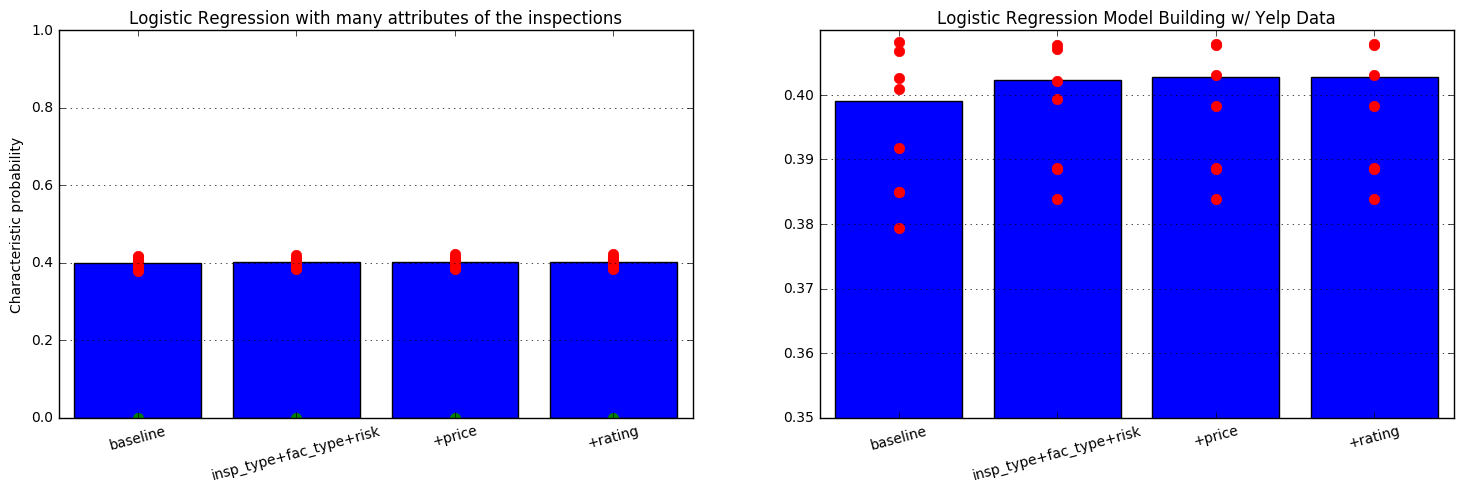

In [51]:
# Plot the characteristic probability for each of the models
plt.figure(figsize=(18,5))
for i in range(2):
    plt.subplot(1,2,i+1)
    mnp = charp.mean(axis=0)
    plt.bar(np.arange(n_models),mnp,align="center")
    mgx,_ = np.meshgrid(range(n_models),range(n_folds))
    plt.plot(mgx,charp,'r.',markersize=15)
    plt.plot(mgx[0,:],charp_insample,'g.',markersize=15)
    plt.xticks(mgx[0,:],model_names,rotation=15)
    plt.ylim([0,1])
    plt.grid(axis='y')
    plt.title('Logistic Regression with many attributes of the inspections')
    if i==1:
        plt.ylim([0.35,0.41])
        plt.title('Logistic Regression Model Building w/ Yelp Data')
    else:
        plt.ylabel('Characteristic probability')
plt.show()